# M2.2 HistogramGradientBoostingClassifier 

## libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import sys

# import custom functions 
sys.path.append(os.path.relpath('../shared_functions/'))
import bwi_dataset_training_funtions as sf

## initalize subdirs 

In [2]:
sf.create_directory_structure()

Created directory: ./metrics
Created directory: ./model
Created directory: ./cross_validation


## load datasets

In [3]:
# read in datasets
data_test = pd.read_csv('../../../datasets/ml_bwi_v3_test.csv')
data_train = pd.read_csv('../../../datasets/ml_bwi_v3_train_imputed.csv', index_col=0)

## split datasets into features, targets and grouping subsets

In [9]:
# split into feautres, targets and groupsc
groups_test, features_test, targets_test = sf.split_input_data(data_test)
groups_train, features_train, targets_train = sf.split_input_data(data_train)

## set up preprocessing for all experiments 

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# set selectors
cat_selector = selector(dtype_include=object)
num_selector = selector(dtype_include=np.number)

# set transformers 
# OHE with handle_unknown='ignore' to ignore unseen categories if appearing
# in the test set (due to the train-test split and imputation)
cat_transformer = OneHotEncoder(handle_unknown='ignore') 
num_transformer = StandardScaler()

# create ColumnTransformer 
preprocessor = ColumnTransformer(
    [
        ('num', num_transformer, num_selector),
        ('cat', cat_transformer, cat_selector)
    ]
)

## HistGradienBoostingClassifier with default paramters - (full) imputed dataset with class weights
We use cross_val_predict here to being able to get a classification report and a correlation matrix which allows us to have a closer look at the effects of class imbalance in the dataset. 

**In the following, the default parameters AND a balanced class weight (inversly to the class ratios) is used** 

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_predict

In [18]:
# HistGradientBoostingClassifier
# we set class weighting inversly to the label distribution
hgdb = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

# create pipeline 
hgdb_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', hgdb)
    ]
)

### cross-val predictions: classification report and confusion-matrix 

In [23]:
# set StratifiedGroupKfold as cv-strategy 
cv = StratifiedGroupKFold(n_splits=5) 

default_hgdb_predictions = cross_val_predict(hgdb_pipe,
                                             features_train,
                                             targets_train,
                                             groups=groups_train['Tnr'],
                                             cv=cv)

              precision    recall  f1-score   support

       Beech       0.97      0.98      0.98     22141
       Birch       0.97      0.98      0.98      3771
 Douglas fir       0.85      0.85      0.85      2441
         Fir       0.57      0.76      0.65      2818
       Larch       0.79      0.90      0.84      2942
      Maples       0.86      0.82      0.84      1938
        Oaks       0.97      0.98      0.98     11752
        Pine       0.98      0.97      0.97     36580
      Spruce       0.98      0.96      0.97     53502

    accuracy                           0.96    137885
   macro avg       0.88      0.91      0.89    137885
weighted avg       0.96      0.96      0.96    137885



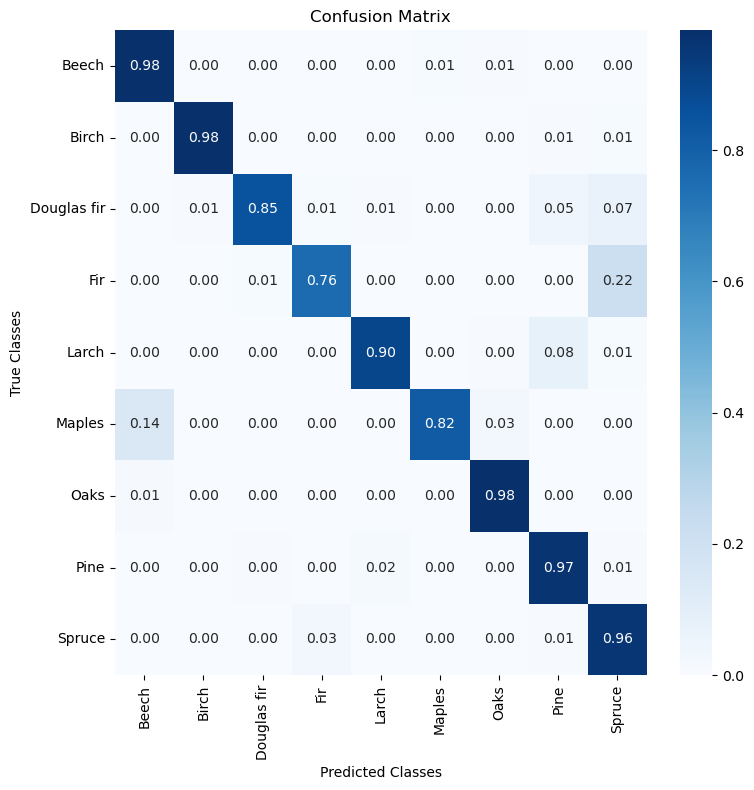

In [ ]:
sf.compute_and_return_metrics(targets_train,
                              default_hgdb_predictions,
                              'default_hgdb_cv')

## HistGradientBoostingClassifier with default parameters - undersampled dataset without class weights 

**In the following an undersampled subset of the (full) imputed trainingset is used to tackle the class imbalance. Since classes are equally distributed after the majority class undersampling, we do not need to set a class weight in the algorithm.**

In [37]:
u_features_train, u_targets_train, u_groups_train = sf.random_undersample(features_train, targets_train, groups_train)

In [ ]:
print(
    f"The undersampled trainingset contains {len(u_targets_train)} samples."
    f"\nThe classes are distributed as follows:\n{u_targets_train.value_counts().to_list()}"
    f"\nThe undersampled trainingset contains {len(u_targets_train)/len(targets_train)*100:.2f}% of the original samples."
)

The undersampled trainingset contains 17442 samples.
The classes are distributed as follows:
[1938, 1938, 1938, 1938, 1938, 1938, 1938, 1938, 1938]
The undersampled trainingset contains 12.65% of the samples.


In [51]:
# HistGradientBoostingClassifier
# we set class weighting inversly to the label distribution
hgdb_u = HistGradientBoostingClassifier(random_state=42)

# create pipeline 
hgdb_pipe_u = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', hgdb_u)
    ]
)

In [52]:
default_hgdb_predictions_u = cross_val_predict(hgdb_pipe_u,
                                             u_features_train,
                                             u_targets_train,
                                             groups=u_groups_train['Tnr'],
                                             cv=cv)

              precision    recall  f1-score   support

       Beech       0.87      0.90      0.89      1938
       Birch       0.98      0.99      0.98      1938
 Douglas fir       0.93      0.86      0.90      1938
         Fir       0.86      0.82      0.84      1938
       Larch       0.92      0.93      0.92      1938
      Maples       0.91      0.84      0.88      1938
        Oaks       0.95      0.96      0.96      1938
        Pine       0.89      0.90      0.89      1938
      Spruce       0.77      0.87      0.82      1938

    accuracy                           0.90     17442
   macro avg       0.90      0.90      0.90     17442
weighted avg       0.90      0.90      0.90     17442



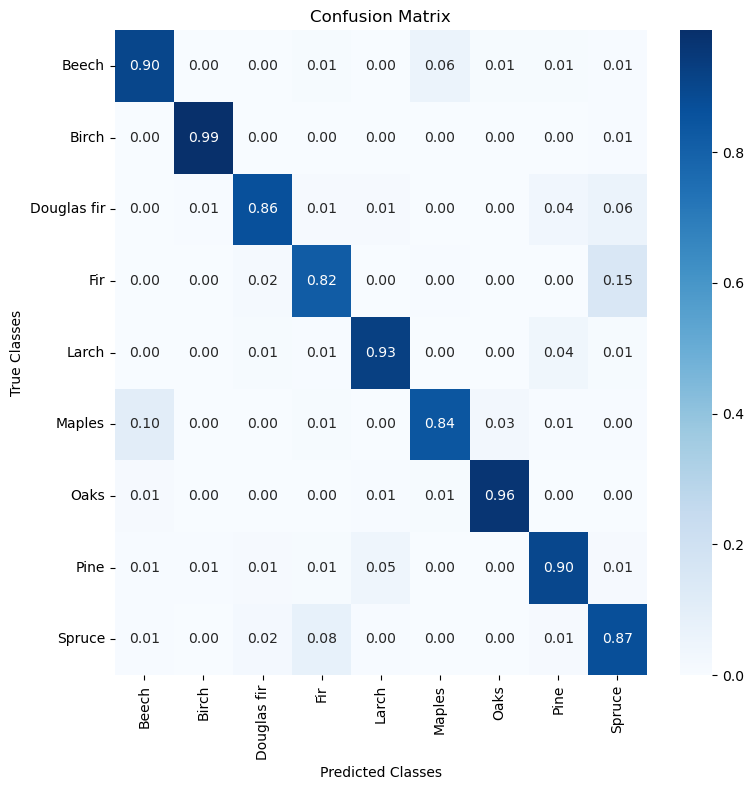

In [66]:
sf.compute_and_return_metrics(u_targets_train,
                              default_hgdb_predictions_u,
                              'default_hgdb_cv_u')

## Randomized Search for HistGradientBoostingClassifier - undersampled dataset without class weights 

In [67]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

In [122]:
# set hyperparameter distribution 
param_distributions = {
    'classifier__max_iter': np.arange(100, 600, 100),
    'classifier__learning_rate': loguniform(0.01, 1),
    'classifier__min_samples_leaf': np.arange(2, 30, 2),
    'classifier__max_leaf_nodes': np.array([2**i for i in range(2, 9)]),
    'classifier__max_features': np.arange(0.1, 1.1, 0.1),
    'classifier__l2_regularization': [0.1, 0.01, 0.001]
}

rsearch_hgdb_u = RandomizedSearchCV(hgdb_pipe_u,
                                   param_distributions=param_distributions,
                                   n_iter=50, # 50iters*5folds = 250 fits
                                   cv=cv,
                                   scoring=['balanced_accuracy',
                                            'f1_macro',
                                            'f1_weighted', 
                                            'recall_weighted',
                                            'precision_macro',
                                            'precision_weighted'],
                                    refit='f1_macro',
                                    n_jobs=-1, # all
)

In [123]:
rsearch_hgdb_u.fit(u_features_train,
                   u_targets_train,
                   groups=u_groups_train['Tnr'])

RandomizedSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000024107762570>),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transfor...
                                        'classifier__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'classifier__max_iter': array([100, 200, 300, 400, 500]),
                                        'classifier__max_leaf_nodes': array([  4,   8,  16,  32,  64, 128, 256]),
                                        'classifier__min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])},
                   refit='f1_macro',
                   scoring=['balanced_accuracy', 'f1_macro', 'f1_weighted',
                            'recall_weighted', 'precision_macro',
                            'precision_weighted'])

In [124]:
import joblib 
joblib.dump(rsearch_hgdb_u, './model/rsearch_hgdb_u.joblib')

['./model/rsearch_hgdb_u.joblib']

In [125]:
rsearch_hgdb_u.best_params_

{'classifier__l2_regularization': 0.001,
 'classifier__learning_rate': np.float64(0.11214862579188793),
 'classifier__max_features': np.float64(1.0),
 'classifier__max_iter': np.int64(300),
 'classifier__max_leaf_nodes': np.int64(16),
 'classifier__min_samples_leaf': np.int64(24)}

In [126]:
rsearch_hgdb_u_cv = pd.DataFrame(rsearch_hgdb_u.cv_results_)
rsearch_hgdb_u_cv.to_csv('./cross_validation/rsearch_hgdb_u_cv.csv')

In [128]:
rsearch_hgdb_u_cv.sort_values(by='mean_test_f1_macro', ascending=False).filter(regex='param*|mean_test*|rank*').head(5)

,param_classifier__l2_regularization,param_classifier__learning_rate,param_classifier__max_features,param_classifier__max_iter,param_classifier__max_leaf_nodes,param_classifier__min_samples_leaf,params,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_f1_macro,rank_test_f1_macro,mean_test_f1_weighted,rank_test_f1_weighted,mean_test_recall_weighted,rank_test_recall_weighted,mean_test_precision_macro,rank_test_precision_macro,mean_test_precision_weighted,rank_test_precision_weighted
19,0.001,0.112149,1.0,300,16,24,"{'classifier__l2_regularization': 0.001, 'clas...",0.907242,1,0.907378,1,0.907375,1,0.907236,1,0.909522,1,0.909523,1
3,0.001,0.075188,1.0,500,16,10,"{'classifier__l2_regularization': 0.001, 'clas...",0.906607,2,0.906667,2,0.906665,2,0.906606,2,0.908675,2,0.908673,2
0,0.001,0.202451,1.0,100,32,20,"{'classifier__l2_regularization': 0.001, 'clas...",0.903573,3,0.903728,3,0.903726,3,0.903567,3,0.905699,3,0.905700,3
32,0.010,0.021853,0.8,500,32,2,"{'classifier__l2_regularization': 0.01, 'class...",0.896518,4,0.896579,4,0.896577,4,0.896515,4,0.898643,4,0.898641,4
41,0.100,0.020920,0.8,500,64,14,"{'classifier__l2_regularization': 0.1, 'classi...",0.894799,5,0.894860,5,0.894856,5,0.894795,5,0.897112,5,0.897108,5


In [129]:
rsearch_hgdb_u_predictions = cross_val_predict(rsearch_hgdb_u.best_estimator_,
                                             u_features_train,
                                             u_targets_train,
                                             groups=u_groups_train['Tnr'],
                                             cv=cv)

              precision    recall  f1-score   support

       Beech       0.89      0.92      0.91      1938
       Birch       0.98      0.99      0.98      1938
 Douglas fir       0.94      0.86      0.90      1938
         Fir       0.87      0.83      0.85      1938
       Larch       0.93      0.94      0.94      1938
      Maples       0.93      0.87      0.90      1938
        Oaks       0.96      0.97      0.97      1938
        Pine       0.90      0.91      0.90      1938
      Spruce       0.78      0.88      0.83      1938

    accuracy                           0.91     17442
   macro avg       0.91      0.91      0.91     17442
weighted avg       0.91      0.91      0.91     17442



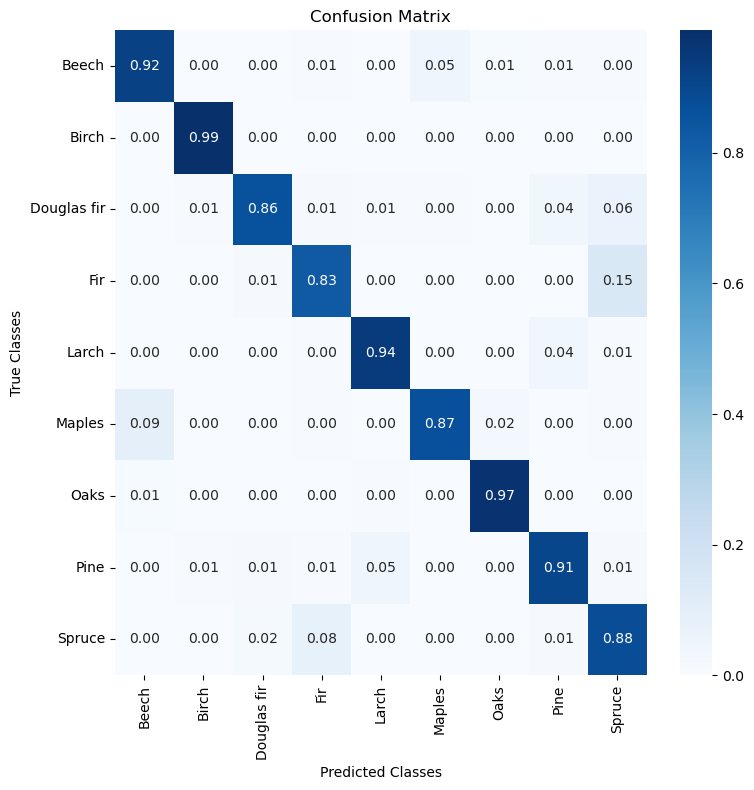

In [130]:
sf.compute_and_return_metrics(u_targets_train,
                              rsearch_hgdb_u_predictions,
                              'rsearch_hgdb_u_cv')

## Randomized Search for HistGradientBoostingClassifier - (full)) imputed dataset with class weights


In [107]:
# set hyperparameter distribution 
param_distributions = {
    'classifier__max_iter': np.arange(100, 600, 100),
    'classifier__min_samples_leaf': np.arange(2, 30, 2),
    'classifier__learning_rate': loguniform(0.01, 1),
    'classifier__max_leaf_nodes': np.array([2**i for i in range(2, 9)]),
    'classifier__max_features': np.arange(0.1, 1.1, 0.1),
    'classifier__l2_regularization': [0.1, 0.01, 0.001]
}

rsearch_hgdb = RandomizedSearchCV(hgdb_pipe,
                                   param_distributions=param_distributions,
                                   n_iter=50, # 50iters*5folds = 250 fits
                                   cv=cv,
                                   scoring=['balanced_accuracy',
                                            'f1_macro',
                                            'f1_weighted', 
                                            'recall_weighted',
                                            'precision_macro',
                                            'precision_weighted'],
                                    refit='f1_macro',
                                    n_jobs=-1, # all
)

In [108]:
rsearch_hgdb.fit(features_train,
                   targets_train,
                   groups=groups_train['Tnr'])

RandomizedSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000024107762570>),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transfor...
                                        'classifier__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'classifier__max_iter': array([100, 200, 300, 400, 500]),
                                        'classifier__max_leaf_nodes': array([  4,   8,  16,  32,  64, 128, 256]),
                                        'classifier__min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])},
                   refit='f1_macro',
                   scoring=['balanced_accuracy', 'f1_macro', 'f1_weighted',
                            'recall_weighted', 'precision_macro',
                            'precision_weighted'])

In [ ]:
joblib.dump(rsearch_hgdb, './model/rsearch_hgdb.joblib')

['./model/rsearch_hgdb.joblib']

In [21]:
rsearch_hgdb = joblib.load('./model/rsearch_hgdb.joblib')
rsearch_hgdb.best_params_


{'classifier__l2_regularization': 0.1,
 'classifier__learning_rate': np.float64(0.09927358247172145),
 'classifier__max_features': np.float64(0.8),
 'classifier__max_iter': np.int64(300),
 'classifier__max_leaf_nodes': np.int64(32),
 'classifier__min_samples_leaf': np.int64(6)}

In [110]:

rsearch_hgdb_cv = pd.DataFrame(rsearch_hgdb.cv_results_)
rsearch_hgdb_cv.to_csv('./cross_validation/rsearch_hgdb_cv.csv')


In [ ]:

rsearch_hgdb_cv.sort_values(by='mean_test_f1_macro', ascending=False)

In [116]:
rsearch_hgdb_predictions = cross_val_predict(rsearch_hgdb.best_estimator_,
                                             features_train,
                                             targets_train,
                                             groups=groups_train['Tnr'],
                                             cv=cv)

              precision    recall  f1-score   support

       Beech       0.98      0.99      0.99     22141
       Birch       0.99      0.98      0.98      3771
 Douglas fir       0.93      0.81      0.87      2441
         Fir       0.74      0.72      0.73      2818
       Larch       0.91      0.89      0.90      2942
      Maples       0.96      0.84      0.90      1938
        Oaks       0.98      0.98      0.98     11752
        Pine       0.98      0.98      0.98     36580
      Spruce       0.98      0.98      0.98     53502

    accuracy                           0.97    137885
   macro avg       0.94      0.91      0.92    137885
weighted avg       0.97      0.97      0.97    137885



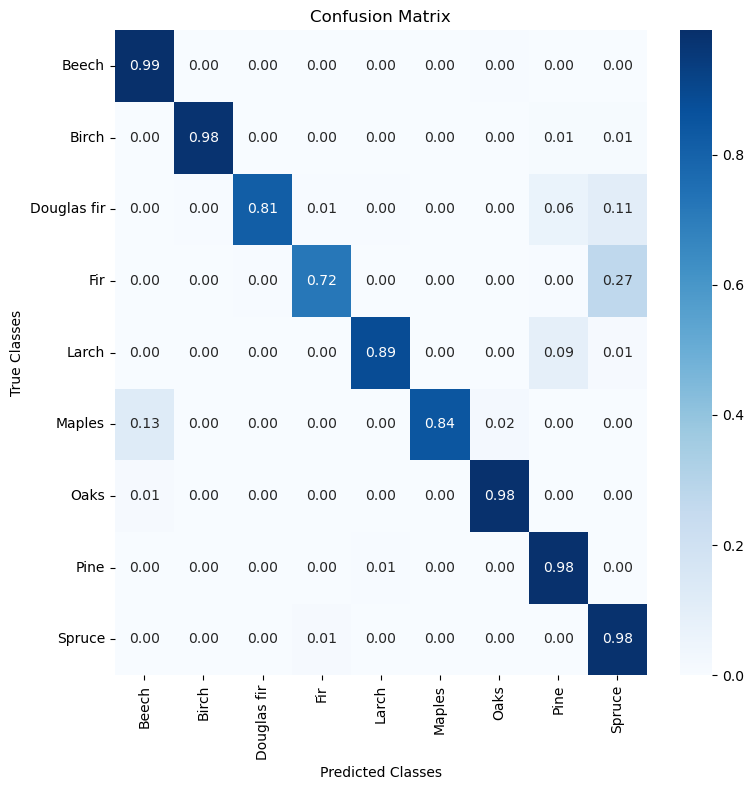

In [117]:
sf.compute_and_return_metrics(targets_train,
                              rsearch_hgdb_predictions,
                              'rsearch_hgdb_cv')

## Final evaluation with the holdout testset 

In [118]:
preds_test = rsearch_hgdb.predict(features_test)

              precision    recall  f1-score   support

       Beech       0.99      1.00      1.00      3397
       Birch       1.00      1.00      1.00       281
 Douglas fir       0.97      0.94      0.95       358
         Fir       0.81      0.83      0.82       489
       Larch       0.90      0.92      0.91       392
      Maples       1.00      0.92      0.96       243
        Oaks       0.99      0.99      0.99      1323
        Pine       0.99      0.98      0.98      2848
      Spruce       0.98      0.99      0.99      7433

    accuracy                           0.98     16764
   macro avg       0.96      0.95      0.95     16764
weighted avg       0.98      0.98      0.98     16764



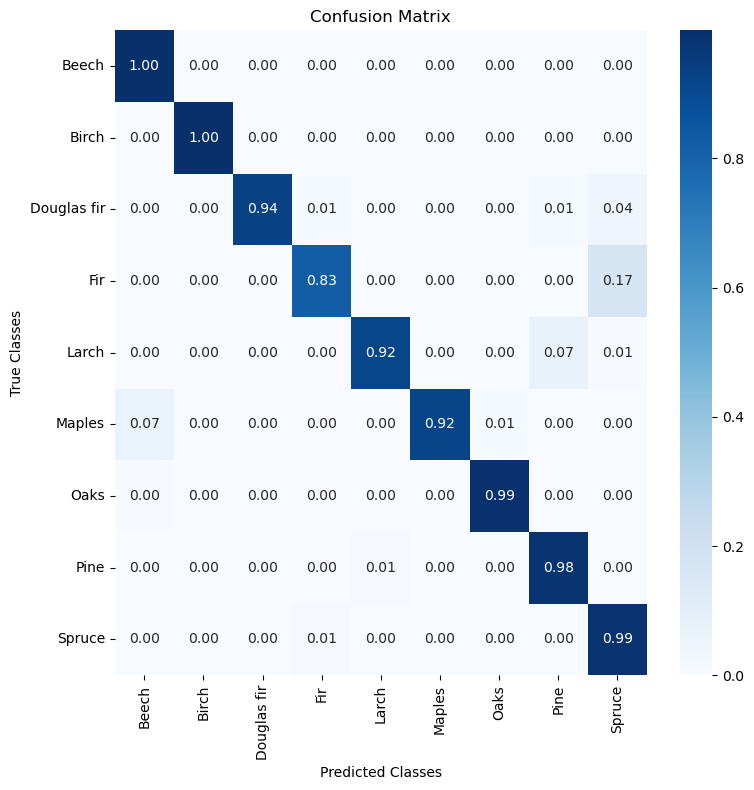

In [119]:
sf.compute_and_return_metrics(targets_test,
                              preds_test,
                              file_name='rsearch_hgdb_final_test')